<br>
<div class= 'alert alert-block alert-danger'>
<b>

### Data Analytics, Machine Learning, Deep Learning on Climate Trace Emission Dataset
#### - Madhur Devkota (04/02/2024)
</b>
<p>
</div>

In [72]:
### local conda venv - gis_ml

import itertools as itools

import pandas as pd
import numpy as np
import pathlib

import geopandas as gpd
import geopandas as pdg
import shapely.geometry as shpy

import rasterio as rio
import rasterio.plot

import rasterio.plot as rioplot
import fiona 
from rasterio.mask import mask as riomask
from rasterio import warp as riowrap
from rasterio.warp import reproject as rioReproject
from patchify import patchify

import keras.layers as klyr
import keras.models as kmodel
import keras.backend as kerasb

import math, os
import random

import json

import matplotlib
import matplotlib.pyplot as plt
# print(  plt.style.available  )

# plt.style.use( style= 'dark_background' )

import xgboost

import seaborn as sns

import sklearn
import sklearn.preprocessing as skPreprocess
from sklearn import model_selection
# import contextily
import missingno as msno

import keras
import tensorflow as tf
# print(  'Num GPUs Available: ', len( tf.config.list_physical_devices('GPU') )  )

from keras import layers as klyr
import cv2
import PIL as pil

import os
os.environ[ 'SM_FRAMEWORK' ] = 'tf.keras'
import glob

import segmentation_models as seg_model

from pprint import pprint

%matplotlib inline
np.random.seed(1)

import wandb
from wandb.keras import WandbCallback as wb_Callback


from IPython.core.display import display, HTML
display(  HTML( '<style>.container { width:98% !important; }</style>' )  )
pd.set_option('display.max_columns', None)

%config Completer.use_jedi = False

DIR_dataset = r'E:\Projects\climateTrace\dataset_usa'
DIR_dataset = r'/mnt/e/Projects/climateTrace/dataset_usa'


##### data

<div class= 'alert alert-block alert-success'>
<b>Automation on Dataset gathering & summarization</b>
<p>

</div>

In [10]:
dir_ls = glob.glob(  os.path.join( DIR_dataset, '**/' ), recursive= True  )[1:]  ## [1:]  to avoid the very root dir
dir_ls

['/mnt/e/Projects/climateTrace/dataset_usa/agriculture/',
 '/mnt/e/Projects/climateTrace/dataset_usa/cb_2016_us_state_5m/',
 '/mnt/e/Projects/climateTrace/dataset_usa/forestry_and_land_use/',
 '/mnt/e/Projects/climateTrace/dataset_usa/fossil_fuel_operations/',
 '/mnt/e/Projects/climateTrace/dataset_usa/manufacturing/',
 '/mnt/e/Projects/climateTrace/dataset_usa/mineral_extraction/',
 '/mnt/e/Projects/climateTrace/dataset_usa/power/',
 '/mnt/e/Projects/climateTrace/dataset_usa/transportation/',
 '/mnt/e/Projects/climateTrace/dataset_usa/waste/']

In [73]:
emission_dictn = dict()

for edir in dir_ls:

    ## inside each sector dir
    file_ls = [  str(efile) for efile in pathlib.Path(edir).rglob( '*.csv' ) ]
    emissionFile_ls = [  efile for efile in file_ls if efile.endswith('_emissions-sources.csv')  ]
    
    sectornm = os.path.basename( os.path.normpath(edir) )
    sectornm = sectornm[:5] + '_df'  ## example: agric_df, fores_df

    concat_df = pd.DataFrame()

    for eEmission in emissionFile_ls:
        _dfi = pd.read_csv( eEmission )
        subSector = os.path.basename(eEmission).replace( '_emissions-sources.csv', '' )   ## clean subsector, ex. manure-management-cattle-feedlot
        _dfi['emission_subsector'] = subSector  ## a col value with subsector for later identification about the subsection source file
        concat_df = pd.concat(  [ concat_df, _dfi ], ignore_index= True )
    
    emission_dictn[sectornm] = concat_df  ## --> put all the section dfs into dict

In [11]:
emission_dictn.keys()

dict_keys(['agric_df', 'cb_20_df', 'fores_df', 'fossi_df', 'manuf_df', 'miner_df', 'power_df', 'trans_df', 'waste_df'])

In [12]:
## extract dataframe (from dictn keys as vars)
globals().update( emission_dictn )
_agric_df =  emission_dictn['agric_df'].copy()
agric_df.head(3)

,source_id,iso3_country,original_inventory_sector,start_time,end_time,temporal_granularity,gas,emissions_quantity,created_date,modified_date,source_name,source_type,lat,lon,other1,other2,other3,other1_def,other2_def,other3_def,geometry_ref,emission_subsector,emissions_factor,emissions_factor_units,capacity,capacity_units,capacity_factor,activity,activity_units,other4,other5,other6,other4_def,other5_def,other6_def,other7,other8,other9,other7_def,other8_def,other9_def
0,10758245,USA,cropland-fires,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,co2,371054.286765,2023-11-03 14:28:00,2023-11-03 14:28:00,Montana,NaN,47.03427,-109.645412,USA.27_1,NaN,1.0,level 1 GADM id,level 2 GADM id,GADM admin level,gadm_USA.27_1,cropland-fires,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11298285,USA,cropland-fires,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,co2,4576.330887,2023-11-03 14:28:00,2023-11-03 14:28:00,Madison,NaN,34.76352,-86.550533,USA.1_1,USA.1.45_1,2.0,level 1 GADM id,level 2 GADM id,GADM admin level,gadm_USA.1.45_1,cropland-fires,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11298285,USA,cropland-fires,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,ch4,8.155843,2023-11-03 14:28:00,2023-11-03 14:28:00,Madison,NaN,34.76352,-86.550533,USA.1_1,USA.1.45_1,2.0,level 1 GADM id,level 2 GADM id,GADM admin level,gadm_USA.1.45_1,cropland-fires,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
## checking exhuastive list of unique gas type in all sections
for k, v_df in emission_dictn.items():
    try: print(  sorted( v_df['gas'].unique() )   )
    except: pass

['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']
['ch4', 'co2', 'co2e_100yr', 'co2e_20yr', 'n2o']


In [14]:
## replace: 'co2', 'co2e_100yr', 'co2e_20yr'  to 'co2' for easiness
## for a dataframe
# agric_df['gas'] = agric_df['gas'].replace( {'co2e_100yr': 'co2', 'co2e_20yr': 'co2'}, regex= True )
for k, v_df in emission_dictn.items():
    try:
        v_df['gas'] = v_df['gas'].replace( {'co2e_100yr': 'co2', 'co2e_20yr': 'co2'}, regex= True )
        print(  sorted( v_df['gas'].unique() )  )
    except: pass

['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']
['ch4', 'co2', 'n2o']


In [15]:
col_ls = [ 'start_time', 'end_time', 'gas','emissions_quantity']

In [74]:
## get summary of the emissions_quantity for each gas type

emiSummary_df = pd.DataFrame()

for k, v_df in emission_dictn.items():
    try:
        v_df['gas'] = v_df['gas'].astype( 'category' )

        dfi = v_df[ ['gas', 'emissions_quantity'] ].groupby( 'gas' ).sum().reset_index()
        dfi['sector'] = k.split('_')[0]

        emiSummary_df = pd.concat(  [ emiSummary_df, dfi ], ignore_index= True  )
    except: pass

In [17]:
# print(  plt.style.available  )

<div class= 'alert alert-block alert-success'>
<b>Exploratory Data Analysis, Visualization, Data Prep</b>
<p>

</div>

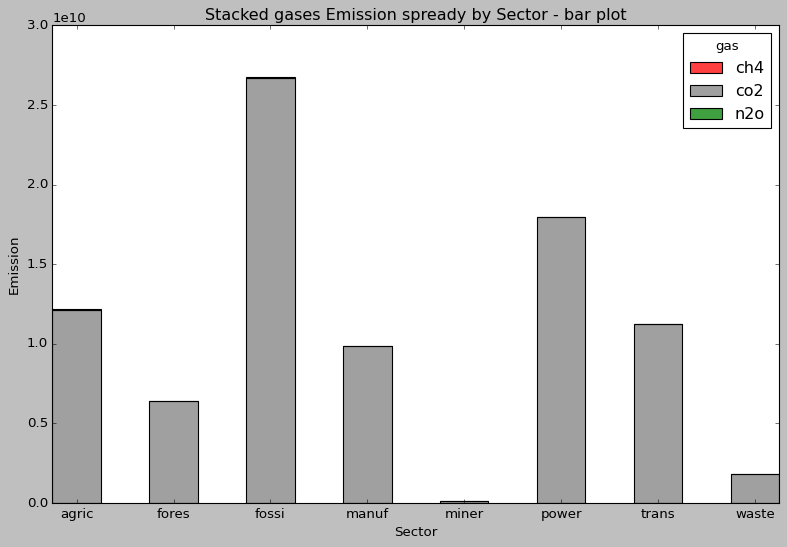

In [18]:
emiSummary_df

plt.style.use( style= 'classic' )

fg, ax = plt.subplots( 1,1, figsize= (10, 7) )
sns.histplot(  emiSummary_df, x= 'sector', hue='gas', weights='emissions_quantity',
               multiple='stack', shrink=0.5, ax= ax, palette= [ 'red', 'gray', 'green' ]   )

plt.xlabel( 'Sector' ); plt.ylabel( 'Emission' ); plt.title( 'Stacked gases Emission spready by Sector - bar plot' )
plt.tight_layout()

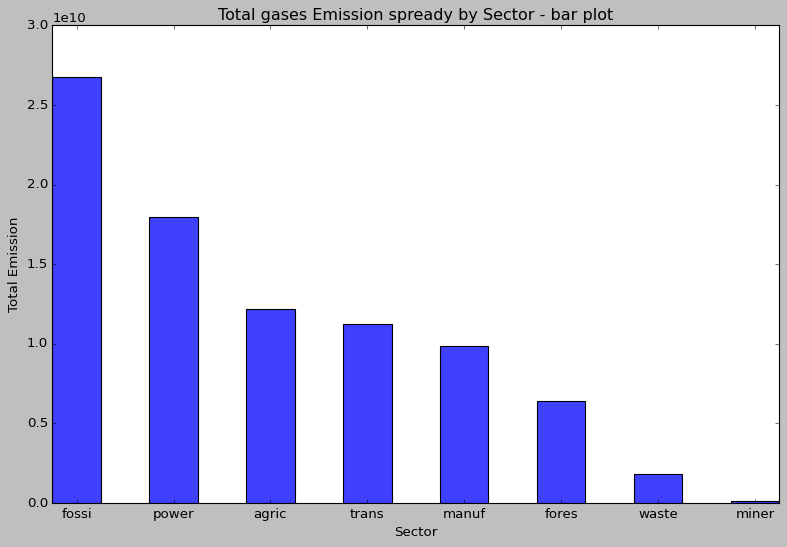

In [19]:
## adding all the emmisions as CH4 & N2O are negligible
emiSum_df = emiSummary_df[ ['sector', 'emissions_quantity'] ].groupby( 'sector' ).sum().reset_index().sort_values( 'emissions_quantity', ascending= False )

plt.style.use( style= 'classic' )

fg, ax = plt.subplots( 1,1, figsize= (10, 7) )
sns.histplot(  emiSum_df, x= 'sector',  weights='emissions_quantity', shrink= 0.5, ax= ax  )

plt.xlabel( 'Sector' ); plt.ylabel( 'Total Emission' ); plt.title( 'Total gases Emission spready by Sector - bar plot' )

plt.tight_layout()

#### picking up Emission by power for further analyis


In [20]:
## picking up Emission by power for further analyis
power_df = emission_dictn['power_df'].copy()
power_df.head()

,source_id,iso3_country,original_inventory_sector,start_time,end_time,temporal_granularity,gas,emissions_quantity,emissions_factor,emissions_factor_units,capacity,capacity_units,capacity_factor,activity,activity_units,created_date,modified_date,source_name,source_type,lat,lon,other1,other2,other3,other4,other1_def,other2_def,other3_def,other4_def,geometry_ref,emission_subsector
0,25448848,USA,electricity-generation,2021-01-01 00:00:00,2021-12-31 00:00:00,annual,n2o,NaN,NaN,field_not_modeled,138,MW,0.324,392000,MWh,2023-10-31 00:00:00,2023-11-01 10:00:00,Gadsden,gas,34.0128,-85.9708,a,NaN,NaN,NaN,field_not_included,biomass_emissions,biomass_capacity,biomass_generation,trace_-85.9708_34.0128,electricity-generation
1,25448848,USA,electricity-generation,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,co2,214000.0,NaN,NaN,138,MW,0.345,417000,MWh,2023-10-31 00:00:00,2023-11-01 10:00:00,Gadsden,gas,34.0128,-85.9708,a,NaN,NaN,NaN,field_not_included,biomass_emissions,biomass_capacity,biomass_generation,trace_-85.9708_34.0128,electricity-generation
2,25448848,USA,electricity-generation,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,co2,214000.0,NaN,NaN,138,MW,0.345,417000,MWh,2023-10-31 00:00:00,2023-11-01 10:00:00,Gadsden,gas,34.0128,-85.9708,a,NaN,NaN,NaN,field_not_included,biomass_emissions,biomass_capacity,biomass_generation,trace_-85.9708_34.0128,electricity-generation
3,25448848,USA,electricity-generation,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,n2o,NaN,NaN,field_not_modeled,138,MW,0.345,417000,MWh,2023-10-31 00:00:00,2023-11-01 10:00:00,Gadsden,gas,34.0128,-85.9708,a,NaN,NaN,NaN,field_not_included,biomass_emissions,biomass_capacity,biomass_generation,trace_-85.9708_34.0128,electricity-generation
4,25448848,USA,electricity-generation,2022-01-01 00:00:00,2022-12-31 00:00:00,annual,ch4,NaN,NaN,field_not_modeled,138,MW,0.345,417000,MWh,2023-10-31 00:00:00,2023-11-01 10:00:00,Gadsden,gas,34.0128,-85.9708,a,NaN,NaN,NaN,field_not_included,biomass_emissions,biomass_capacity,biomass_generation,trace_-85.9708_34.0128,electricity-generation


In [21]:
## clean up the data, simplifying it (I might have removed important columns, but its just for a sake of simplicity)

_power_df = (   power_df.copy()
    .drop( columns= [ 'iso3_country', 'original_inventory_sector', 'temporal_granularity', 'capacity_units', 'activity_units', 'created_date', 'source_name', 'other1', 'other1_def', 'emission_subsector', 'emissions_factor_units'  ] )
    .rename(  columns= {  'other2': 'biomass_emissions', 'other3': 'biomass_capacity', 'other4': 'biomass_generation' }  )
    .drop( columns= [ 'other2_def', 'other3_def', 'other4_def'  ] )

    ## explode based on 'source_type' col
    .assign(  source_type = lambda df: df['source_type'].str.split(',')  )
    .explode(  'source_type', ignore_index= True  )
    .assign( source_type = lambda df: df['source_type'].astype('category') )
    .reset_index( drop= True )

    ## convert object into datetime
    .assign(   start_time = lambda df: pd.to_datetime( df['start_time'] ),
               end_time = lambda df: pd.to_datetime( df['end_time'] )   )

    # clean 'source_type' column
    .assign(   source_type = lambda df: df['source_type'].str.strip().str.lower()  )

    ## remove alaska and hawaai for simplicity
    [ lambda df: df['lon'] > -130 ]   ## OR .query('lon > -130')

    # .dropna( subset= ['emissions_quantity'] )
    ## get a geometry column using lat lon
    .assign(    geometry = lambda df: df.apply(  lambda _df: shpy.Point( _df['lon'], _df['lat'] ), axis= 1  )    )
)

_power_df.head()

,source_id,start_time,end_time,gas,emissions_quantity,emissions_factor,capacity,capacity_factor,activity,modified_date,source_type,lat,lon,biomass_emissions,biomass_capacity,biomass_generation,geometry_ref,geometry
0,25448848,2021-01-01,2021-12-31,n2o,NaN,NaN,138,0.324,392000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.9708 34.0128)
1,25448848,2022-01-01,2022-12-31,co2,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.9708 34.0128)
2,25448848,2022-01-01,2022-12-31,co2,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.9708 34.0128)
3,25448848,2022-01-01,2022-12-31,n2o,NaN,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.9708 34.0128)
4,25448848,2022-01-01,2022-12-31,ch4,NaN,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.9708 34.0128)


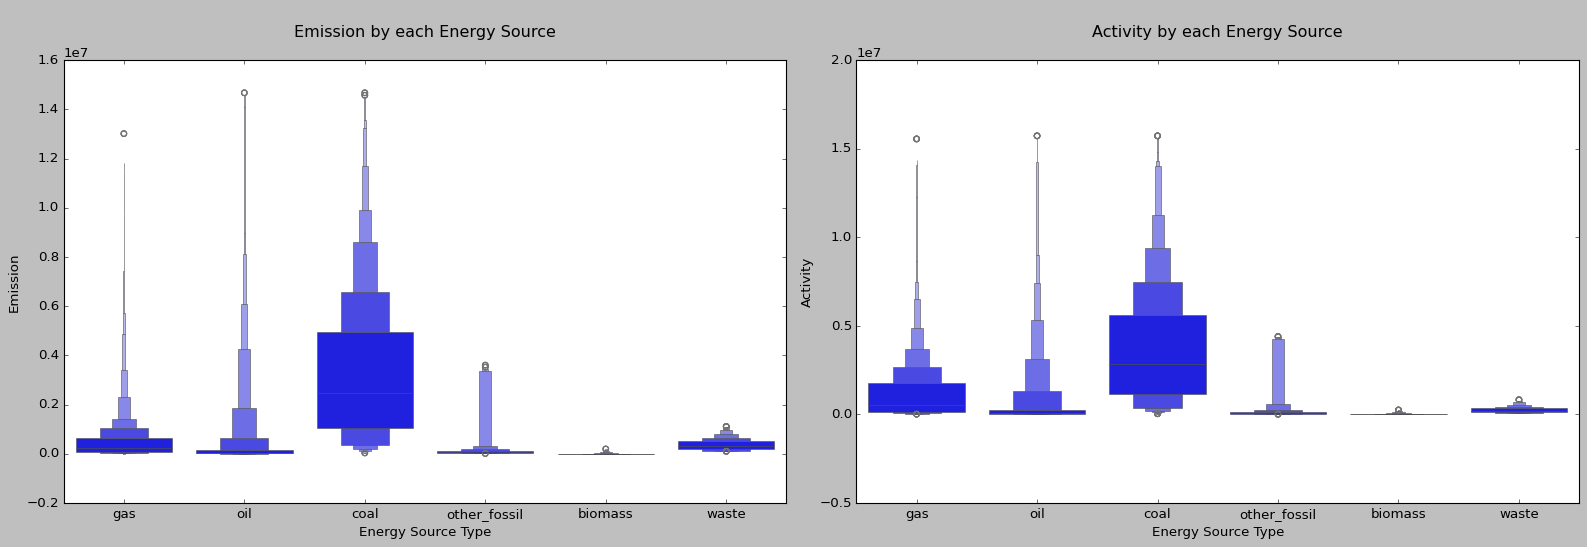

In [22]:
## some EDA plots
fg, ax = plt.subplots(  1,2, figsize= ( 20, 7 )  ) 

sns.boxenplot(  data= _power_df,  y= 'emissions_quantity', x= 'source_type', ax= ax[0]  )
ax[0].set_xlabel( 'Energy Source Type' ); ax[0].set_ylabel( 'Emission' );ax[0].set_title( '\nEmission by each Energy Source\n' )
ax[1].set_xlabel( 'Energy Source Type' ); ax[1].set_ylabel( 'Activity' ); ax[1].set_title( '\nActivity by each Energy Source\n' )

sns.boxenplot(  data= _power_df,  y= 'activity', x= 'source_type', ax= ax[1]  )

plt.tight_layout()

In [24]:
## convert pandas into geopandas so that it have goespatial info
power_gpd = gpd.GeoDataFrame( _power_df.copy(), geometry= 'geometry', crs= 'EPSG:2264' )
## plotting only CO2
powerCo2_gpd = ( power_gpd.copy()
    [  lambda df: df['gas'] == 'co2'  ]
    .drop( columns= 'gas' )
    .assign(  emi_log = lambda df: np.log2( df['emissions_quantity'] )  )
    [  lambda df: df['emi_log'] != -np.inf  ]  ## remove -np.inf from emi_log
)
print(  powerCo2_gpd.shape  )
powerCo2_gpd.head()

,source_id,start_time,end_time,emissions_quantity,emissions_factor,capacity,capacity_factor,activity,modified_date,source_type,lat,lon,biomass_emissions,biomass_capacity,biomass_generation,geometry_ref,geometry,emi_log
1,25448848,2022-01-01,2022-12-31,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251
2,25448848,2022-01-01,2022-12-31,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251
5,25448848,2022-01-01,2022-12-31,214000.0,0.513,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251
6,25448848,2021-01-01,2021-12-31,201000.0,NaN,138,0.324,392000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.616836
7,25448848,2021-01-01,2021-12-31,201000.0,NaN,138,0.324,392000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.616836


In [25]:
state_san_ls = [  'Alaska', 'American Samoa', 'Guam', 'Hawaii', 'Puerto Rico', 'United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands' ]

import shapely
from shapely import geometry as shpy_Geom
clip_box = shpy_Geom.box( -150, 25, -60, 50 )  ## xmin, ymin, xmax, ymax (longitude, latitude)
print( clip_box )


usa_shp = os.path.join( DIR_dataset, 'cb_2016_us_state_5m/cb_2016_us_state_5m.shp' )
_usa_gdf = gpd.read_file( usa_shp )
# usa_shp = os.path.join( DIR_dataset, 'cb_2016_us_state_5m/cb_2016_us_state_5m.shp' )
usa_gdf = (   _usa_gdf.copy()
    
    [  lambda df:  ~df['NAME'].isin( state_san_ls )  ]
    ## remove clip the polygon outside clip_box for aesthetic purpose
    .assign(   geometry = lambda df: df['geometry'].intersection( clip_box )  )

    ## convert crs to that of powerCo2_gpd
    # .to_crs( powerCo2_gpd.crs )
)
usa_gdf.head()

POLYGON ((-60 25, -60 50, -150 50, -150 25, -60 25))


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"MULTIPOLYGON (((-88.03661 30.52049, -88.02473 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.80939 32.61712, -114.79756 32.6..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.05954 38.71989, -109.05739 38.7..."
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.69595 41.11543, -73.63967 41.141..."
5,12,00294478,0400000US12,12,FL,Florida,00,138924199212,31386038155,"MULTIPOLYGON (((-82.25578 26.70344, -82.25516 ..."


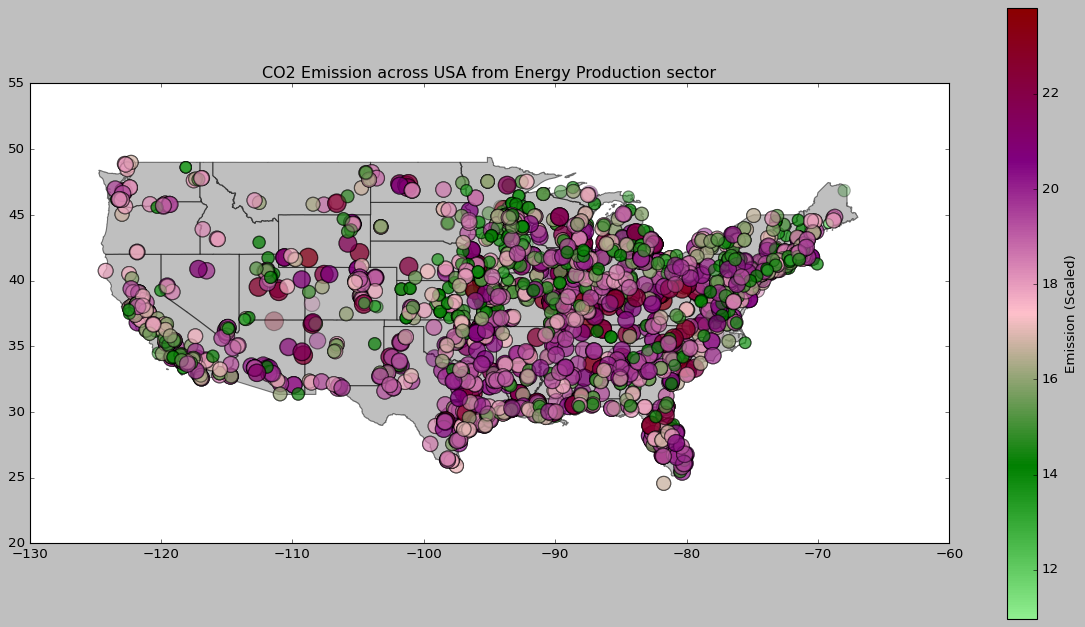

In [26]:
plt.style.use( style= 'classic' )

custom_color = [ 'lightgreen', 'green', 'pink', 'purple',  'darkred' ]
# Create a colormap object
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom_pal', custom_color )

fg, ax = plt.subplots( figsize= (15,8) )
usa_gdf.plot( ax= ax, color= 'grey', alpha= 0.5 )
powerCo2_gpd.plot(  markersize= powerCo2_gpd['emi_log'] **1.8 , column= 'emi_log',
                    ax= ax, cmap= custom_cmap, alpha= 0.1, legend=True, legend_kwds= { 'label': 'Emission (Scaled)' }  ) 
plt.title( 'CO2 Emission across USA from Energy Production sector' )

plt.tight_layout()

In [27]:
## get population data by states

uspop_df = (   pd.read_csv(  os.path.join( DIR_dataset, 'us_pop_by_state.csv' )  )
    .drop( columns= [ 'rank', 'percent_of_total']  )
    .replace(  { 'DC' : 'District of Columbia'  }  )

)
uspop_df.head()

,state,state_code,2020_census
0,California,CA,39538223
1,Texas,TX,29145505
2,Florida,FL,21538187
3,New York,NY,20201249
4,Pennsylvania,PA,13002700


<div class= 'alert alert-block alert-success'>
<b>Python Geospatial library</b>
<p>
Adopting Geopandas and producing Geospatial Analytics maps
</div>

In [29]:
## Spatial Join to get total emission per state

powerUSA_gdf = (  powerCo2_gpd[  [ 'source_id', 'emissions_quantity', 'geometry', 'activity' ]  ]
    .sjoin( usa_gdf[ ['STUSPS', 'NAME', 'geometry'] ], how= 'inner', predicate= 'within' )
    
    .groupby( 'NAME' )[['emissions_quantity']].sum().reset_index()  ## groupby for summar
    .merge(  usa_gdf[['STUSPS', 'NAME', 'geometry']], how= 'right', on= 'NAME'  )
    .pipe(  lambda df: gpd.GeoDataFrame( df, geometry= 'geometry', crs= usa_gdf.crs )  )

    ## join with population data 
    .merge( uspop_df, how= 'left', left_on= 'NAME', right_on= 'state' )
    .drop(  columns= [ 'STUSPS', 'NAME' ]  )
    .rename(  columns= { '2020_census': 'pop2020' }  )
    
)
powerUSA_gdf.head()

,emissions_quantity,geometry,state,state_code,pop2020
0,6.531870e+08,"MULTIPOLYGON (((-88.03661 30.52049, -88.02473 ...",Alabama,AL,5024279
1,3.939960e+08,"POLYGON ((-114.80939 32.61712, -114.79756 32.6...",Arizona,AZ,7151502
2,3.362700e+08,"POLYGON ((-109.05954 38.71989, -109.05739 38.7...",Colorado,CO,5773714
3,1.884900e+08,"POLYGON ((-73.69595 41.11543, -73.63967 41.141...",Connecticut,CT,3605944
4,1.399278e+09,"MULTIPOLYGON (((-82.25578 26.70344, -82.25516 ...",Florida,FL,21538187


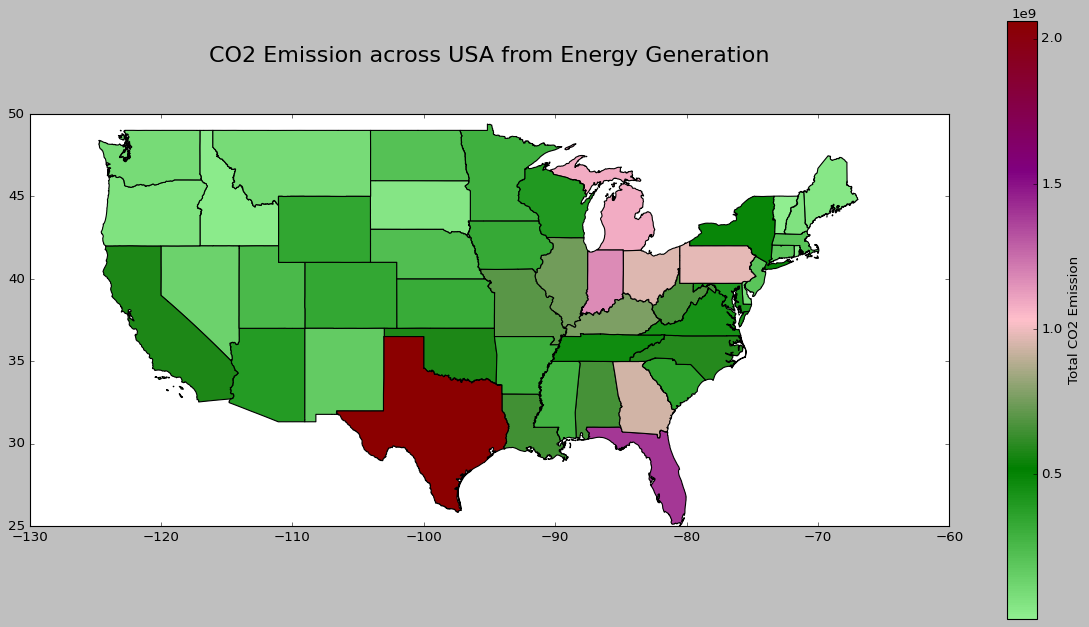

In [30]:
plt.style.use( style= 'classic' )

custom_color = [ 'lightgreen', 'green', 'pink', 'purple',  'darkred' ]
# Create a colormap object
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom_pal', custom_color )

fg, ax = plt.subplots( figsize= (15,8) )
powerUSA_gdf.plot( ax= ax, column= 'emissions_quantity', cmap= custom_cmap, legend=True, legend_kwds= { 'label': 'Total CO2 Emission' } )
plt.title( 'CO2 Emission across USA from Energy Generation\n\n', fontsize= 20 )

plt.tight_layout()

In [32]:
## normalizing the emission based on state area
powerUSA_gdf = (  powerUSA_gdf

    ## calc state area
    .assign(  area = lambda df: df.area  )
    ## normalized emission amount per area
    .assign(
        ## normalized emission amount per area
        emission_AreaNorm = lambda df: df.apply( lambda _df: _df['emissions_quantity']/_df['area'], axis= 1 ),
        ## normalized emission amount per population ( emission per capita)
        emission_PopNorm = lambda df: df.apply( lambda _df: _df['emissions_quantity']/_df['pop2020'], axis= 1 )
        ## i understand the emission contains data from 2019 to 2022 but the pop is from 2020, but this is only to demonstarte how the norm value would be vastly different then the raw "un-normalized"
    )
    
)
powerUSA_gdf.head()

,emissions_quantity,geometry,state,state_code,pop2020,area,emission_AreaNorm,emission_PopNorm
0,6.531870e+08,"MULTIPOLYGON (((-88.03661 30.52049, -88.02473 ...",Alabama,AL,5024279,12.899239,5.063764e+07,130.006116
1,3.939960e+08,"POLYGON ((-114.80939 32.61712, -114.79756 32.6...",Arizona,AZ,7151502,28.921795,1.362281e+07,55.092762
2,3.362700e+08,"POLYGON ((-109.05954 38.71989, -109.05739 38.7...",Colorado,CO,5773714,28.039251,1.199283e+07,58.241541
3,1.884900e+08,"POLYGON ((-73.69595 41.11543, -73.63967 41.141...",Connecticut,CT,3605944,1.396975,1.349272e+08,52.272026
4,1.399278e+09,"MULTIPOLYGON (((-82.25578 26.70344, -82.25516 ...",Florida,FL,21538187,13.903939,1.006390e+08,64.967307


'<div class= 'alert alert-block alert-success'>
<b>Geostatistical Analysis & Viz.</b>
<p>
Visualizing raw data & Normalized data on a map.
</div>

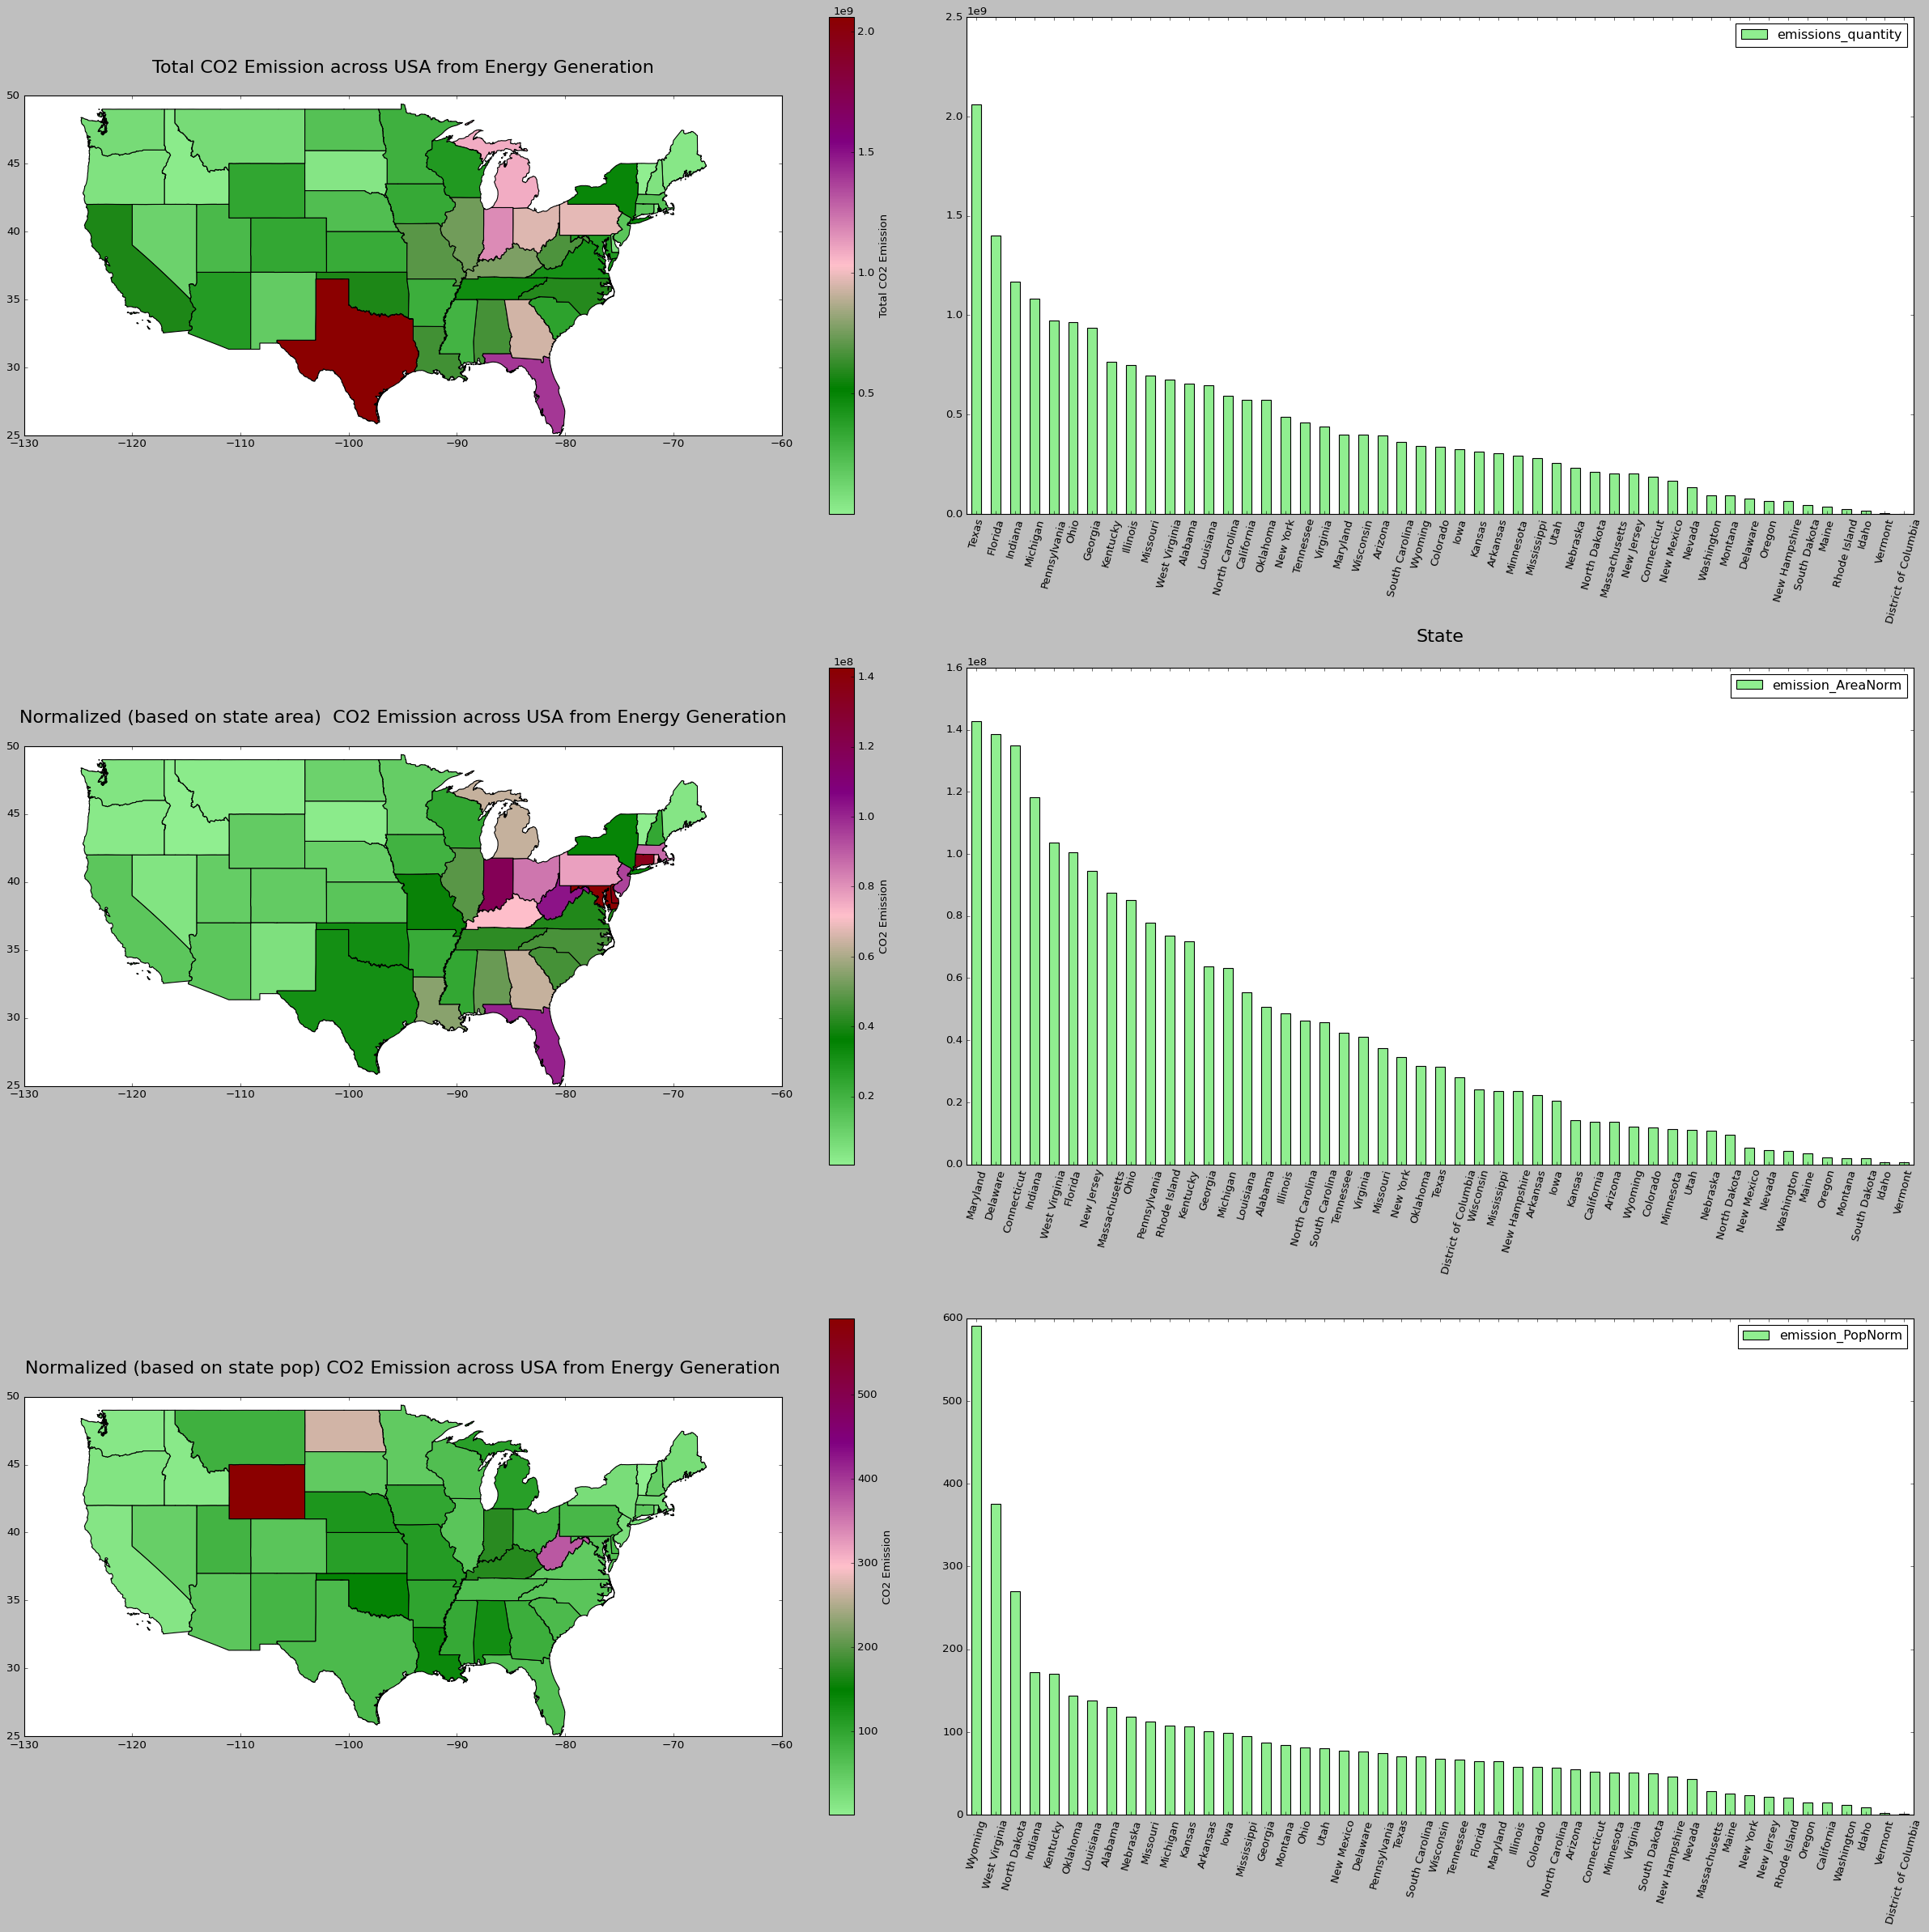

In [33]:
plt.style.use( style= 'classic' )


custom_color = [ 'lightgreen', 'green', 'pink', 'purple',  'darkred' ]
# Create a colormap object
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom_pal', custom_color )

fg, ax = plt.subplots( 3, 2, figsize= (30,30) )

powerUSA_gdf.plot( ax= ax[0][0], column= 'emissions_quantity', cmap= custom_cmap, legend=True, legend_kwds= { 'label': 'Total CO2 Emission' } )
ax[0][0].set_title( '\n\nTotal CO2 Emission across USA from Energy Generation\n', fontsize= 20 )

powerUSA_gdf = powerUSA_gdf.sort_values( 'emissions_quantity', ascending= False  )
powerUSA_gdf.plot( kind= 'bar', ax= ax[0][1], x= 'state', y = 'emissions_quantity', cmap= custom_cmap, legend=True )
ax[0][1].set_xticklabels( powerUSA_gdf['state'], rotation= 75 )
ax[0][1].set_xlabel( 'State', fontsize= 20 )

powerUSA_gdf.plot( ax= ax[1][0], column= 'emission_AreaNorm', cmap= custom_cmap, legend=True, legend_kwds= { 'label': 'CO2 Emission' } )
ax[1][0].set_title( '\n\nNormalized (based on state area)  CO2 Emission across USA from Energy Generation\n', fontsize= 20 )

powerUSA_gdf = powerUSA_gdf.sort_values( 'emission_AreaNorm', ascending= False  )
powerUSA_gdf.plot( kind= 'bar', ax= ax[1][1], x= 'state', y = 'emission_AreaNorm', cmap= custom_cmap, legend=True)
ax[1][1].set_xticklabels( powerUSA_gdf['state'], rotation= 75 )
ax[1][1].set_xlabel( '' )


powerUSA_gdf.plot( ax= ax[2][0], column= 'emission_PopNorm', cmap= custom_cmap, legend=True, legend_kwds= { 'label': 'CO2 Emission' } )
ax[2][0].set_title( '\n\nNormalized (based on state pop) CO2 Emission across USA from Energy Generation\n', fontsize= 20 )

powerUSA_gdf = powerUSA_gdf.sort_values( 'emission_PopNorm', ascending= False  )
powerUSA_gdf.plot( kind= 'bar', ax= ax[2][1], x= 'state', y = 'emission_PopNorm', cmap= custom_cmap, legend=True)
ax[2][1].set_xticklabels( powerUSA_gdf['state'], rotation= 75 )
ax[2][1].set_xlabel( '' )

plt.tight_layout()

<div class= 'alert alert-block alert-danger'>
<b>NOTE:</b> Analysis & Insights
<p>
So even though Texas & Florida are high on total CO2 emission, area wise, Maryland, Delaware & Connecticut have higher emission per unit area; New Jersey is also around higher side for the emission per unit area.

Likewise Emission per capital is way higher at Wyoming, followed by West Virginia and then N Dakota. The emission per capita is way lesser in New York & New Jersey compared to total emission. These insights becomes conspicuous only after analyzing normalized data.
</div>

<div class= 'alert alert-block alert-success'>
<b>
Developing Machine Learning model to estimates emissions_quantity
</b>
<p>
</div>

In [34]:
powerUSA_gdf.head(3)

,emissions_quantity,geometry,state,state_code,pop2020,area,emission_AreaNorm,emission_PopNorm
48,340962000.0,"POLYGON ((-111.05563 44.93358, -111.05621 44.9...",Wyoming,WY,576851,27.971856,1.218947e+07,591.074645
24,673569000.0,"POLYGON ((-82.63905 38.17111, -82.62546 38.170...",West Virginia,WV,1793716,6.493955,1.037225e+08,375.515968
17,210693000.0,"POLYGON ((-104.04882 48.86754, -104.04888 48.8...",North Dakota,ND,779094,21.839790,9.647208e+06,270.433350


In [35]:
powerCo2_gpd.head(3)

,source_id,start_time,end_time,emissions_quantity,emissions_factor,capacity,capacity_factor,activity,modified_date,source_type,lat,lon,biomass_emissions,biomass_capacity,biomass_generation,geometry_ref,geometry,emi_log
1,25448848,2022-01-01,2022-12-31,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251
2,25448848,2022-01-01,2022-12-31,214000.0,NaN,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251
5,25448848,2022-01-01,2022-12-31,214000.0,0.513,138,0.345,417000,2023-11-01 10:00:00,gas,34.0128,-85.9708,NaN,NaN,NaN,trace_-85.9708_34.0128,POINT (-85.971 34.013),17.707251


<div class= 'alert alert-block alert-success'>
<b>
Feature Engineering
</b>
<p>
</div>

In [38]:
## Developing Machine Learning model to estimates emissions_quantity
print(  powerCo2_gpd['emissions_quantity'].isnull().sum()  )

powerCo2_df = (  powerCo2_gpd.copy()
    # .drop(  columns= [ 'geometry', 'geometry_ref' ]  )
    .drop(  columns= [ 'emi_log', 'end_time', 'modified_date', 'source_id', 'start_time', 'lat', 'lon' ]  )
    .assign(   source_type = lambda df: df['source_type'].astype('category')  )

    ## spatial join with powerUSA_gdf to get state area and pop
    .sjoin(  powerUSA_gdf[ ['state', 'geometry', 'area', 'pop2020' ] ], how= 'inner', predicate= 'within'  )
    .drop(  columns= [ 'geometry', 'geometry_ref', 'index_right' ], errors= 'ignore' )
    .reset_index( drop= True )
)

powerCo2_df.head()

0


,emissions_quantity,emissions_factor,capacity,capacity_factor,activity,source_type,biomass_emissions,biomass_capacity,biomass_generation,state,area,pop2020
0,214000.0,NaN,138,0.345,417000,gas,NaN,NaN,NaN,Alabama,12.899239,5024279
1,214000.0,NaN,138,0.345,417000,gas,NaN,NaN,NaN,Alabama,12.899239,5024279
2,214000.0,0.513,138,0.345,417000,gas,NaN,NaN,NaN,Alabama,12.899239,5024279
3,201000.0,NaN,138,0.324,392000,gas,NaN,NaN,NaN,Alabama,12.899239,5024279
4,201000.0,NaN,138,0.324,392000,gas,NaN,NaN,NaN,Alabama,12.899239,5024279


#### Feature Normalization ( Min max )

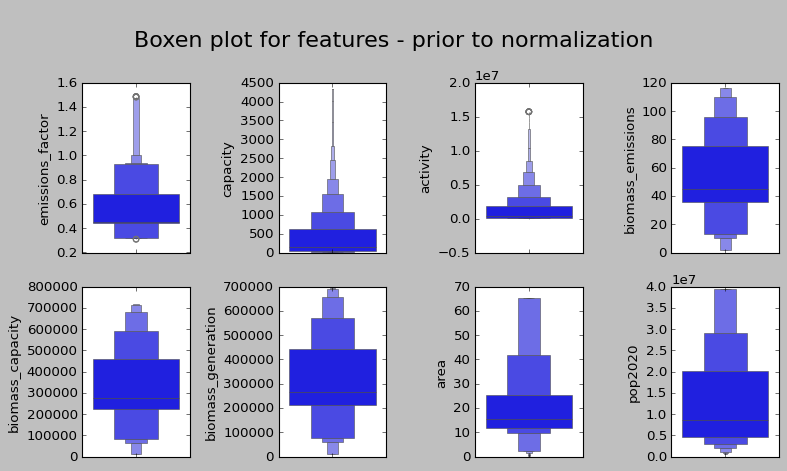

In [39]:
## prior to normalizaion
# distribution prior to normalization
feature2norm_ls = [ 'emissions_factor', 'capacity', 'activity',  'biomass_emissions', 'biomass_capacity', 'biomass_generation', 'area', 'pop2020'  ]

ncol = 4
nrow = math.ceil(  len(feature2norm_ls)/ncol )

fg, ax = plt.subplots( nrow,ncol, figsize= (10,3*nrow) )
for e_c, e_ax in zip( feature2norm_ls, ax.flatten() ):
    sns.boxenplot( y= powerCo2_df[e_c], ax= e_ax )
plt.suptitle( '\nBoxen plot for features - prior to normalization', fontsize= 20 )
plt.tight_layout()

In [40]:
powerCo2Norm_df = (   pd.DataFrame(  data= sklearn.preprocessing.MinMaxScaler().fit_transform( powerCo2_df[feature2norm_ls] ), columns= feature2norm_ls  )
    .pipe(  lambda df: pd.concat( [ df, powerCo2_df.drop( columns= feature2norm_ls ) ], axis= 'columns' )  )
    .reset_index( drop= True )
)
powerCo2Norm_df

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,source_type,state
0,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,gas,Alabama
1,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,gas,Alabama
2,0.173876,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,gas,Alabama
3,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.114150,201000.0,0.324,gas,Alabama
4,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.114150,201000.0,0.324,gas,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...
26542,0.011026,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,gas,Michigan
26543,NaN,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,gas,Michigan
26544,NaN,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,gas,Michigan
26545,NaN,0.007625,0.006296,NaN,NaN,NaN,0.261120,0.243844,32000.0,0.329,gas,Michigan


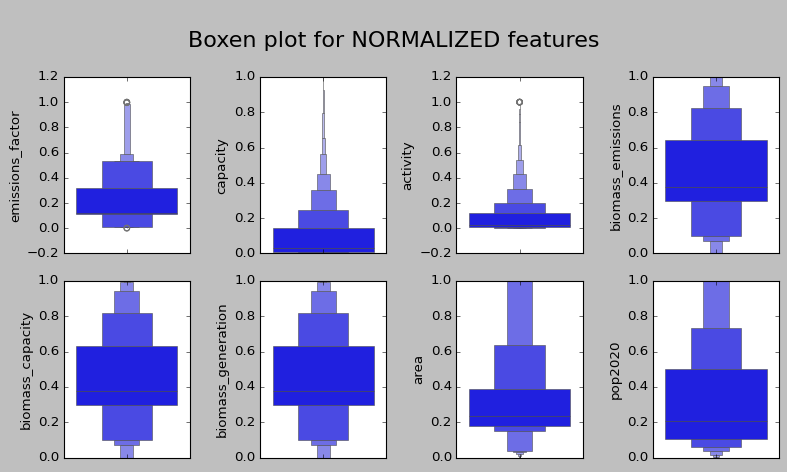

In [41]:
# distribution prior to normalization
ncol = 4
nrow = math.ceil(  len(feature2norm_ls)/ncol )

fg, ax = plt.subplots( nrow,ncol, figsize= (10,3*nrow) )
for e_c, e_ax in zip( feature2norm_ls, ax.flatten() ):
    sns.boxenplot( y= powerCo2Norm_df[e_c], ax= e_ax )
plt.suptitle( '\nBoxen plot for NORMALIZED features', fontsize= 20 )

plt.tight_layout(); plt.show()

In [42]:
print( powerCo2Norm_df['source_type'].isnull().sum() )
powerCo2Norm_df.head()

0


,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,source_type,state
0,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,gas,Alabama
1,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,gas,Alabama
2,0.173876,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,gas,Alabama
3,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.11415,201000.0,0.324,gas,Alabama
4,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.11415,201000.0,0.324,gas,Alabama


In [43]:
## converting categorical col (sourceType) into OHE
OHEncoder_obj = sklearn.preprocessing.OneHotEncoder( sparse_output= False, drop= 'first', dtype= int )

_powerCo2Norm_df = (  powerCo2Norm_df
    .rename(  columns= { 'source_type': 'sourceType' }  )           
    .pipe(  lambda df:
        pd.concat(   [ df, pd.DataFrame(  OHEncoder_obj.fit_transform( df[['sourceType']] ),
                                          index= df.index, columns= OHEncoder_obj.get_feature_names_out( ['sourceType'] )  )   ],
                    axis= 'columns' 
                 )
    )
    .drop( columns= ['sourceType', 'state'] )

)
_powerCo2Norm_df

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,sourceType_coal,sourceType_gas,sourceType_oil,sourceType_other_fossil,sourceType_waste
0,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,0,1,0,0,0
1,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,0,1,0,0,0
2,0.173876,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.114150,214000.0,0.345,0,1,0,0,0
3,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.114150,201000.0,0.324,0,1,0,0,0
4,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.114150,201000.0,0.324,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26542,0.011026,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,0,1,0,0,0
26543,NaN,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,0,1,0,0,0
26544,NaN,0.007625,0.006614,NaN,NaN,NaN,0.261120,0.243844,34000.0,0.346,0,1,0,0,0
26545,NaN,0.007625,0.006296,NaN,NaN,NaN,0.261120,0.243844,32000.0,0.329,0,1,0,0,0


<div class= 'alert alert-block alert-success'>
<b>
Fix missing values by interpolating using ML algorithms
</b>
<p>
</div>

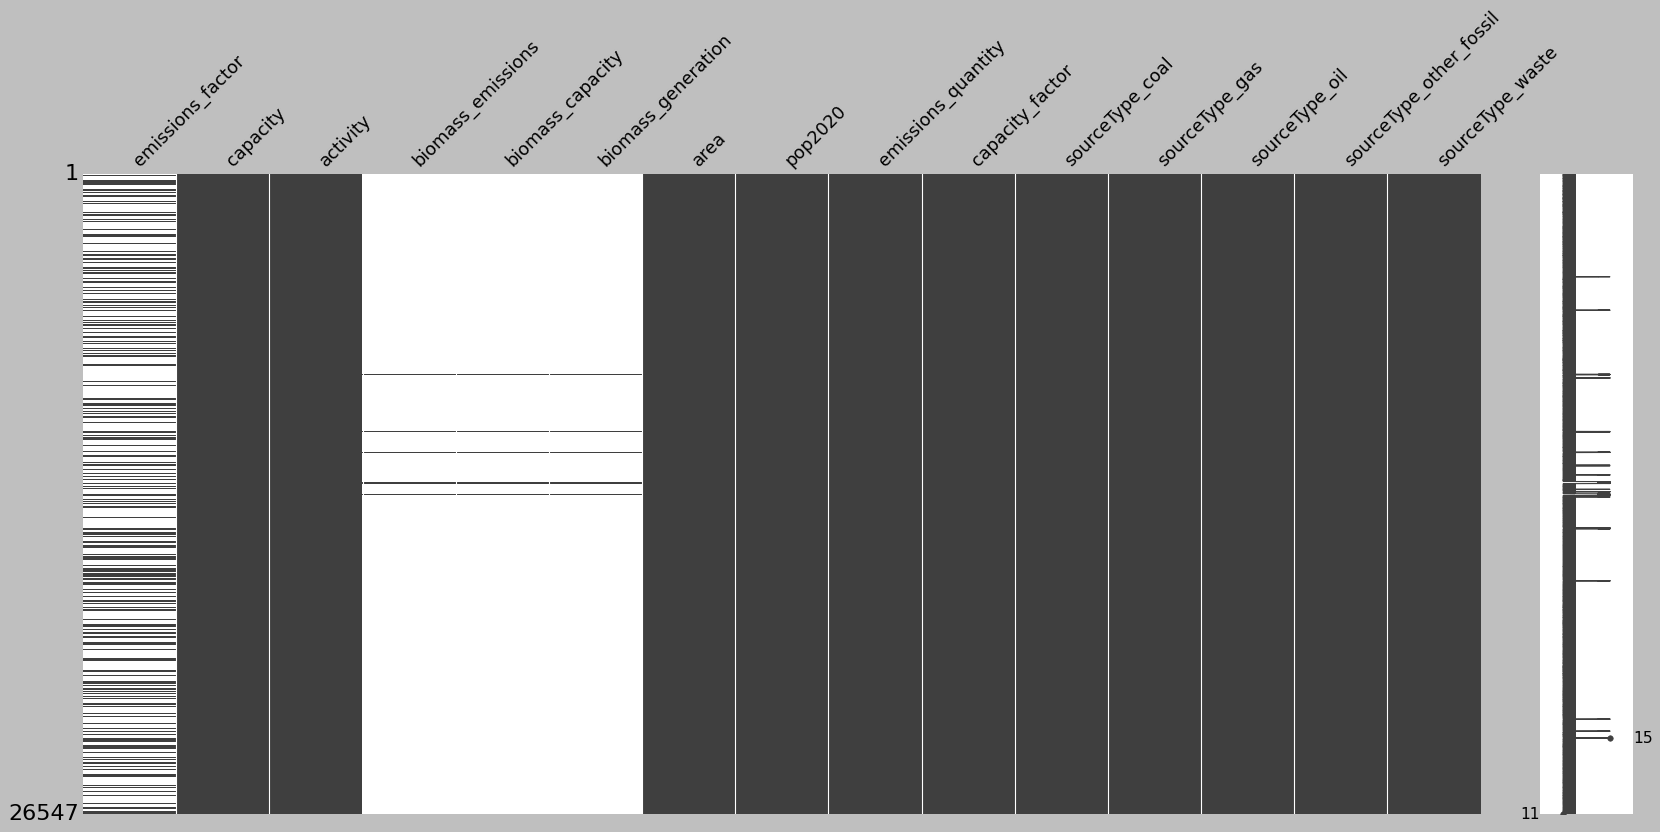

In [44]:
## visualizing missing data
msno.matrix( _powerCo2Norm_df );

In [45]:
_powerCo2Norm_df.head(3)

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,sourceType_coal,sourceType_gas,sourceType_oil,sourceType_other_fossil,sourceType_waste
0,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0
1,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0
2,0.173876,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0


<div class= 'alert alert-block alert-info'>
<b>NOTE:</b> Reminder!!

using Machine learning approach to interpolate missing values
though imputing feature whichh have ample data missing is not recommended, I am just doing to show how one can adopt ML algo
for imputing the data itself prior to applying ML algo for predictive analysis).
</div>

In [47]:
# Impute missing values using BayesianRidge
import fancyimpute as fimpute

imputer_obj = fimpute.IterativeImputer(  estimator= sklearn.linear_model.BayesianRidge(), max_iter= 100, initial_strategy= 'mean',
                                        imputation_order= 'random', skip_complete= False, verbose=2   )

powerCo2Imput_df = pd.DataFrame(  imputer_obj.fit_transform( _powerCo2Norm_df ), columns= _powerCo2Norm_df.columns  )
                            
powerCo2Imput_df

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,sourceType_coal,sourceType_gas,sourceType_oil,sourceType_other_fossil,sourceType_waste
0,0.140753,0.031423,0.026391,0.437052,0.435298,0.436227,0.197121,0.114150,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
1,0.140753,0.031423,0.026391,0.437052,0.435298,0.436227,0.197121,0.114150,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
2,0.173876,0.031423,0.026391,0.436982,0.435269,0.436157,0.197121,0.114150,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
3,0.145383,0.031423,0.024801,0.436868,0.435321,0.436132,0.197121,0.114150,201000.0,0.324,0.0,1.0,0.0,0.0,0.0
4,0.145383,0.031423,0.024801,0.436868,0.435321,0.436132,0.197121,0.114150,201000.0,0.324,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26542,0.011026,0.007625,0.006614,0.440325,0.435530,0.435578,0.261120,0.243844,34000.0,0.346,0.0,1.0,0.0,0.0,0.0
26543,0.138436,0.007625,0.006614,0.440711,0.435470,0.435424,0.261120,0.243844,34000.0,0.346,0.0,1.0,0.0,0.0,0.0
26544,0.138436,0.007625,0.006614,0.440711,0.435470,0.435424,0.261120,0.243844,34000.0,0.346,0.0,1.0,0.0,0.0,0.0
26545,0.141717,0.007625,0.006296,0.440653,0.435472,0.435429,0.261120,0.243844,32000.0,0.329,0.0,1.0,0.0,0.0,0.0


In [35]:
### using NEural Network to impute missing data

In [48]:
import fancyimpute as fimpute
import sklearn.neural_network 
# from sklearn.neural_network import MLPRegressor

# Impute numerical columns using IterativeImputer with MLPRegressor
imputer_obj = fimpute.IterativeImputer(
    estimator=  sklearn.neural_network.MLPRegressor(
                        hidden_layer_sizes= (100,50,25,10), activation= 'relu', solver= 'adam',
                        batch_size= 100, learning_rate='adaptive', 
                        max_iter= 1000, early_stopping= True, validation_fraction= 0.1, random_state= 42,
                        verbose= 0
                )
)
# _powerCo2Imput_df = pd.DataFrame(  imputer_obj.fit_transform( _powerCo2Norm_df ), columns= _powerCo2Norm_df.columns  )


<div class= 'alert alert-block alert-danger'>
<b>NOTE:</b> Reminder!!
<p>
again as a reminder that imputing features where majority values (say more than 30% are missing) is not recommended. But here it is adopted just to illustrate that values can be imputed using ML algorithms
</div>

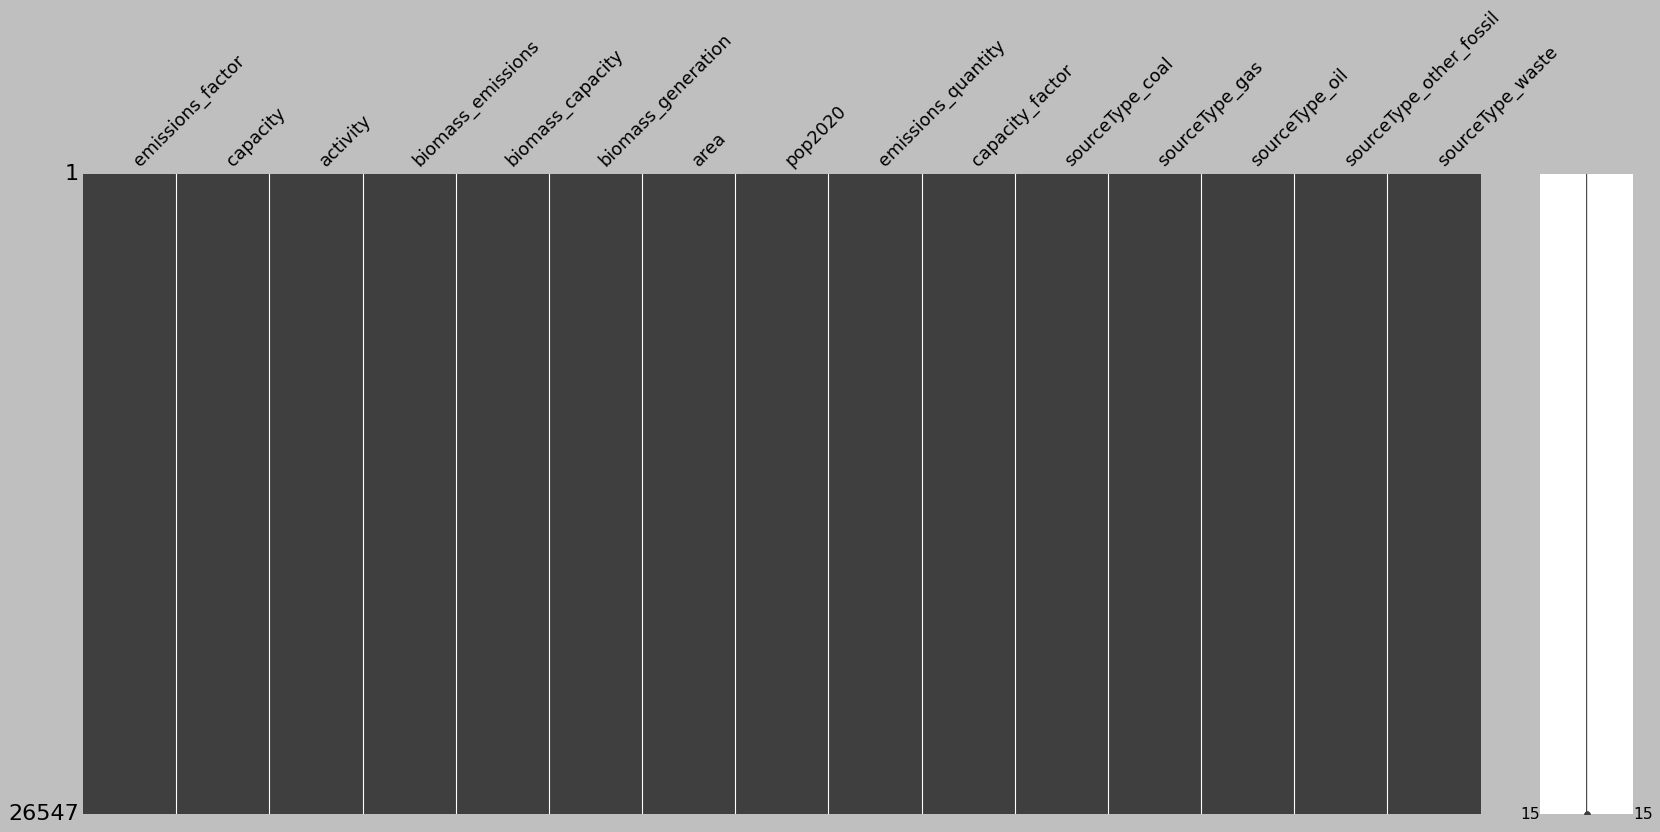

In [49]:
## No missing data after imputation
msno.matrix( powerCo2Imput_df );

##### Machine learning modeling

In [50]:
powerCo2Imput_df.head()

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,sourceType_coal,sourceType_gas,sourceType_oil,sourceType_other_fossil,sourceType_waste
0,0.140753,0.031423,0.026391,0.437052,0.435298,0.436227,0.197121,0.11415,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
1,0.140753,0.031423,0.026391,0.437052,0.435298,0.436227,0.197121,0.11415,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
2,0.173876,0.031423,0.026391,0.436982,0.435269,0.436157,0.197121,0.11415,214000.0,0.345,0.0,1.0,0.0,0.0,0.0
3,0.145383,0.031423,0.024801,0.436868,0.435321,0.436132,0.197121,0.11415,201000.0,0.324,0.0,1.0,0.0,0.0,0.0
4,0.145383,0.031423,0.024801,0.436868,0.435321,0.436132,0.197121,0.11415,201000.0,0.324,0.0,1.0,0.0,0.0,0.0


In [51]:
## train test
xtrn, xtst, ytrn, ytst  = sklearn.model_selection.train_test_split(
                powerCo2Imput_df.drop(columns= ['emissions_quantity']).to_numpy(),
                powerCo2Imput_df['emissions_quantity'].to_numpy(),
                train_size= 75./100, random_state= 10 )

<div class= 'alert alert-block alert-success'>
<b>
Extreme Gradient Boosting (XGBoost) modeling
</b>
<p>
</div>

In [53]:
xgboost_est = xgboost.XGBRegressor( objective= 'reg:squarederror', eval_metric= 'logloss', n_estimators= 500, max_depth= 100, colsample_bytree= 50/100,
                                    reg_lambda = 0.35,
                                    booster= 'gbtree', use_label_encoder= False )
## fit the model
xgb_fit = xgboost_est.fit( xtrn, ytrn )

In [58]:
_powerCo2Norm_df.head()

,emissions_factor,capacity,activity,biomass_emissions,biomass_capacity,biomass_generation,area,pop2020,emissions_quantity,capacity_factor,sourceType_coal,sourceType_gas,sourceType_oil,sourceType_other_fossil,sourceType_waste
0,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0
1,NaN,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0
2,0.173876,0.031423,0.026391,NaN,NaN,NaN,0.197121,0.11415,214000.0,0.345,0,1,0,0,0
3,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.11415,201000.0,0.324,0,1,0,0,0
4,NaN,0.031423,0.024801,NaN,NaN,NaN,0.197121,0.11415,201000.0,0.324,0,1,0,0,0


In [60]:
yhat = xgb_fit.predict( xtst )

ytst_yhat_xgb_df =  pd.DataFrame( [ytst,yhat] ).T
ytst_yhat_xgb_df.columns= [ 'ytst', 'yhat' ]
ytst_yhat_xgb_df.head()

,ytst,yhat
0,1006000.0,1.006000e+06
1,148000.0,1.527264e+05
2,245000.0,2.450000e+05
3,358000.0,3.557058e+05
4,21000.0,2.100000e+04


In [61]:
acc_xgb1 = sklearn.metrics.root_mean_squared_error( ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )
acc_xgb2 = sklearn.metrics.r2_score(  ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )
acc_xgb3 = sklearn.metrics.mean_absolute_error(  ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )

print( f'XGBoost accuracy: \nroot_mean_squared_error --> {acc_xgb1} \nr2_score --> {acc_xgb2} \nmean_absolute_error --> {acc_xgb3}, {abs( ytst - yhat ).mean()}' )

XGBoost accuracy: 
root_mean_squared_error --> 21978.520176843616 
r2_score --> 0.9998152586448482 
mean_absolute_error --> 5356.337016195458, 5356.337016195458


<div class= 'alert alert-block alert-info'>
<b>Interpretation of the model</b>
<p>

The XG Boost model have a R2 of 0.999, which indicates a superb fit. It tells us that the model explains nearly 99.9% of the variation in the target variable we're trying to predict. In simpler terms, the model captures almost of the underlying trends in the data.

Mean Absolute Error (MAE): 5356.337

This metric represents the average absolute difference between actual values and predictions. So, it tells that the average amount of error, regardless of whether the prediction was an overestimate or underestimate.
A value of around 5356 suggests that, on average, the model's predictions are off by this amount in the units of the target variable.


Thus, we can predict the CO2 Emission if we have the following info:
[ 'emissions_factor', 'capacity', 'capacity_factor', 'activity', 'biomass_emissions', 'biomass_capacity', 'biomass_generation', 'state area', 'state population' , 'sourceType']

I genuinely understand that predicting CO2 Emission using these info may not be a sincere business problem, but I just created a MAchine Learning model using advanced algorithm (XGBoost) to demonstarte a modeling task using Climate TRACE emission data.

</div>

<br>
<div class= 'alert alert-block alert-success'>
<b>
Investigating the significance of the features
</b>
<p>
</div>

In [75]:
## ! pip install shap
import shap

In [ ]:
shapExplainer =  shap.Explainer( model= xgb_fit )

In [ ]:
xtrn, xtst, ytrn, ytst  = sklearn.model_selection.train_test_split(
                powerCo2Imput_df.drop(columns= ['emissions_quantity']),
                powerCo2Imput_df[['emissions_quantity']],
                train_size= 75./100, random_state= 10 )

In [ ]:
shapVal_np = shapExplainer( X= xtrn )

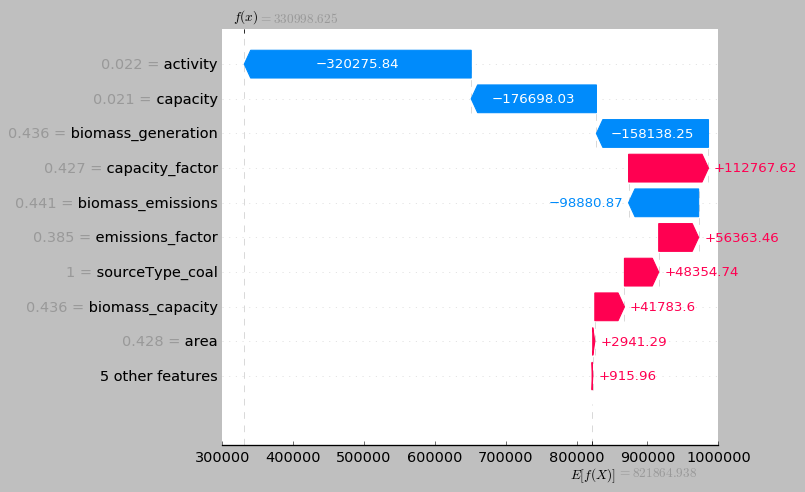

In [ ]:
# visualize the first prediction's explanation
shap.plots.waterfall( shap_values= shapVal_np[0] )

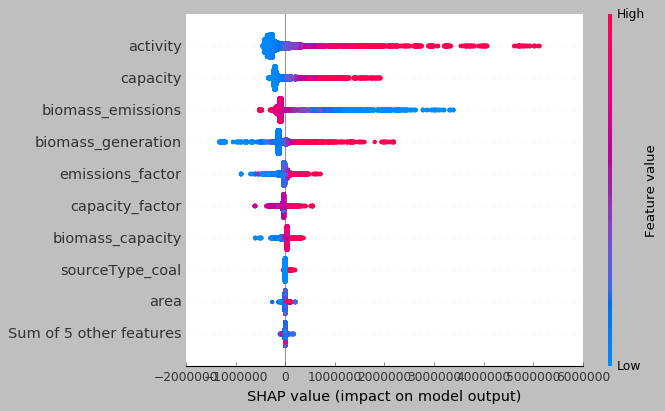

In [ ]:
shap.plots.beeswarm( shap_values= shapVal_np  )


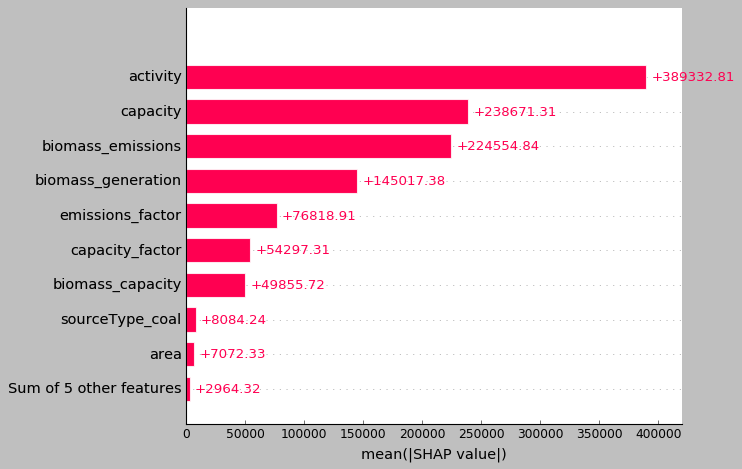

In [ ]:
shap.plots.bar( shap_values= shapVal_np )

<div class= 'alert alert-block alert-info'>
<b>
Interpreting SHAP plots
</b>
<p>

From the above 3 plots, we can observe that the feature `Activity`, `Capacity` have the highest positive impact on the CO2 emission, while the `Coal` among the other source type have the highest influence. The `Capcity Factor` & `Emission Factor` have the negative corelation to the Emission.
</div>

<div class= 'alert alert-block alert-success'>
<b>

### Develop Deep Neural Network for predict CO2 Emission
</b>
<p>

		- Developed Neural Network with appropriate activation, no of nodes, apt no of layers
		- Compiled using apt loss & optimizer function
		- Developed Callback object for automatic learning stopping based on apt criteria
		- Saved the best model checkpoint for future analysis without needing to retrain the data


</div>

In [64]:
kerasSeqModel1 = keras.Sequential(  [
     klyr.Dense(  units= 100, activation= 'relu', input_shape= ( xtrn.shape[-1], )  )
    ,klyr.Dense(  units= 50, activation= 'relu'  )
    ,klyr.Dense(  units= 25, activation= 'relu'  )
    ,klyr.Dense(  units= 10, activation= 'relu' )
    ,klyr.Dense(  units= 5, activation= 'relu'  )
    ,klyr.Dense(  1, activation= None  )  # DONT provide any activation functions such as 'sigmoid', 'relu', 'softmax' for 
    ]  
)

kerasSeqModel1.compile(  loss= 'mean_squared_error', optimizer= 'adam'  )

ESmonitor = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-3, patience= 350, verbose= 1, mode= 'auto', restore_best_weights= True  )

In [48]:
# kerasSeqModel_fit = kerasSeqModel1.fit(  xtrn, ytrn, validation_data= (xtst,ytst), callbacks= [ESmonitor], verbose= 2, epochs= 100000  )

## this line takes more than a day, so commenting out for now

In [67]:
# kerasSeqModel1.save( 'emission_prediction_NeuralNwModel.keras' )
kerasSeqModel2 = keras.models.load_model( 'emission_prediction_NeuralNwModel.keras' )

In [66]:
yhat = kerasSeqModel2.predict( x= xtst )

 30/208 [===>..........................] - ETA: 0s  

2024-04-02 23:15:58.154255: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


208/208 [==============================] - 1s 2ms/step


In [68]:
ytst_yhat_NN_df = (  pd.DataFrame( ytst.copy(), columns= ['ytst'] )
    .assign(  yhat=  pd.DataFrame( yhat ) )
)
ytst_yhat_NN_df.head()

,ytst,yhat
0,1006000.0,995484.125000
1,148000.0,137747.875000
2,245000.0,239693.687500
3,358000.0,353082.718750
4,21000.0,17128.455078


<div class= 'alert alert-block alert-success'>
<b>

### Comparison of models' ( Deep Neural Network vs XGBoost ) scoring 
</b>
<p>



</div>

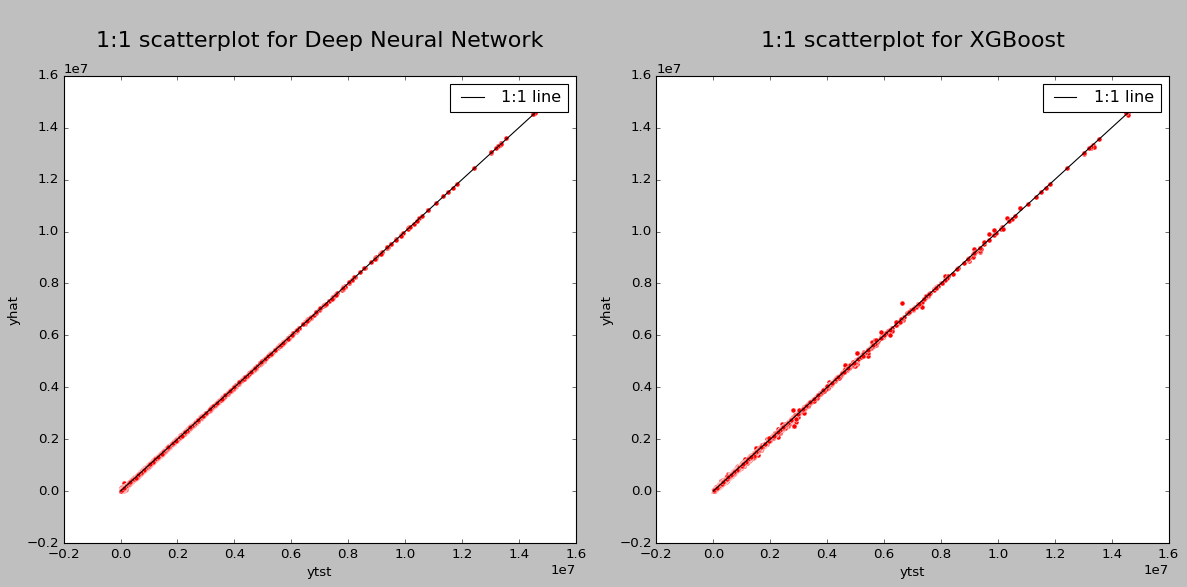

In [69]:
fg, ax = plt.subplots( 1, 2, figsize= (15, 7.5 ) )

minmax = [ ytst_yhat_NN_df.min().min(), ytst_yhat_NN_df.max().max() ]
ax[0].plot( minmax, minmax, color= 'black', linestyle= '-', label= '1:1 line'  )  
sns.scatterplot( data= ytst_yhat_NN_df, x= 'ytst', y= 'yhat', ax= ax[0], color= 'red' )
ax[0].set_title( '\n1:1 scatterplot for Deep Neural Network\n', fontsize= 20 )

minmax = [ ytst_yhat_xgb_df.min().min(), ytst_yhat_xgb_df.max().max() ]
ax[1].plot( minmax, minmax, color= 'black', linestyle= '-', label= '1:1 line'  )  
sns.scatterplot( data= ytst_yhat_xgb_df, x= 'ytst', y= 'yhat', ax= ax[1], color= 'red' )
ax[1].set_title( '\n1:1 scatterplot for XGBoost\n', fontsize= 20 )


plt.tight_layout()

In [70]:
## metrics score for Deep Neural Network model prediction

acc_dnn1 = sklearn.metrics.root_mean_squared_error( ytst_yhat_NN_df.ytst, ytst_yhat_NN_df.yhat )
acc_dnn2 = sklearn.metrics.r2_score( ytst_yhat_NN_df.ytst, ytst_yhat_NN_df.yhat )
acc_dnn3 = sklearn.metrics.mean_absolute_error( ytst_yhat_NN_df.ytst, ytst_yhat_NN_df.yhat  )
print( f'Deep Neural Network accuracy: \nroot_mean_squared_error --> {acc_dnn1} \nr2_score --> {acc_dnn2} \nmean_absolute_error --> {acc_dnn3}' )

Deep Neural Network accuracy: 
root_mean_squared_error --> 9476.661372424003 
r2_score --> 0.9999656538585605 
mean_absolute_error --> 6492.299969336203


In [71]:
## metrics score for XGBoost model prediction
acc_xgb1 = sklearn.metrics.root_mean_squared_error( ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )
acc_xgb2 = sklearn.metrics.r2_score(  ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )
acc_xgb3 = sklearn.metrics.mean_absolute_error(  ytst_yhat_xgb_df.ytst, ytst_yhat_xgb_df.yhat  )

print( f'XGBoost accuracy: \nroot_mean_squared_error --> {acc_xgb1} \nr2_score --> {acc_xgb2} \nmean_absolute_error --> {acc_xgb3}' )

XGBoost accuracy: 
root_mean_squared_error --> 21978.520176843616 
r2_score --> 0.9998152586448482 
mean_absolute_error --> 5356.337016195458


<div class= 'alert alert-block alert-success'>
<b>Comparison of the performance of Deep Neural Network & XGBoost </b>
<p>
CO2 Emission Prediction: DNN vs XGBoost <p>
Two models were evaluated for CO2 emission prediction: DNN and XGBoost. Both achieved high accuracy (R² > 0.9998). However, DNN outperformed XGBoost with a significantly lower RMSE (9476.66 vs 21978.52) indicating closer predictions to actual values.

DNN's strength likely lies in capturing complex, non-linear relationships between influencing factors, potentially due to its automatic feature learning capabilities.

<br>
Important Caveats:

This analysis is based on the provided metrics and may not translate to all CO2 emission prediction scenarios.
Further investigation into the interpretability of the DNN model might be necessary to understand the factors influencing its predictions.<br>
It's recommended to consider these factors and potentially evaluate the models on a held-out test set for a more robust comparison.

</div>